## Human Face Detection using Injection Layer in YOLOv8n Model

Members:

- Jelin Raphael Akkara (2072064)
- Davide Checchia (2078232)
- Kiamehr Javid (2084294)

## Loading Libraries

In [1]:
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

import comet_ml

import json
import os
from PIL import Image
import shutil
import copy

In [2]:
import sys

ultralytics_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked'
sys.path.append(ultralytics_dir)

from ultralytics import YOLO

## Preprocessing Data

In [3]:
#Parent directory for data
data_dir = r'E:\Academics\UniPD\Courses\Semester_3\Vision and Cognitive Systems\Projects\data'

#Directories for original data, and data formatted for YOLO
ch_data_dir = data_dir + r'\CrowdHuman'
yolo_ch_data_dir = data_dir + r'\yolo_CrowdHuman'

#Original Data for images
train_dir = ch_data_dir + r'\CrowdHuman_train01\Images'
val_dir = ch_data_dir + r'\CrowdHuman_val\Images'
test_dir = ch_data_dir + r'\CrowdHuman_test\images_test'

#Original Data for annotations
val_annot_odgt = ch_data_dir + r'\annotation_val.odgt'
train_annot_odgt = ch_data_dir + r'\annotation_train.odgt'

#Original Image shapes data
train_shapes_path = data_dir + r'\train_img_shapes.txt'
val_shapes_path = data_dir + r'\val_img_shapes.txt'

#YOLO formatted Training annotations
train_annot_body_dir = yolo_ch_data_dir + r'\train_annots_body'
train_annot_face_dir = yolo_ch_data_dir + r'\train_annots_face'
train_annot_both_dir = yolo_ch_data_dir + r'\train_annots_both'

#YOLO formatted Validation annotations
val_annot_body_dir = yolo_ch_data_dir + r'\val_annots_body'
val_annot_face_dir = yolo_ch_data_dir + r'\val_annots_face'
val_annot_both_dir = yolo_ch_data_dir + r'\val_annots_both'


#YOLO formatted data directory (only body)
data_body_dir = data_dir + r'\yolo_data_body'
data_body_yaml = data_dir + r'\data_body_meta.yaml'

#YOLO formatted data directory (only face)
data_face_dir = data_dir + r'\yolo_data_face'
data_face_yaml = data_dir + r'\data_face_meta.yaml'

#YOLO formatted data directory (both body and face)
data_both_dir = data_dir + r'\yolo_data_both'
data_both_yaml = data_dir + r'\data_both_meta.yaml'

#### Obtaining Image Shapes

Obtains shapes of images for normalizing bounding box coordinates.

In [9]:
#Obtain list of image shapes from text file, if file does not exist, create the text file
# data_dir: Parent Directory
# shapes_txt: Name of text file to save at
# mode_dir: Type of file (train/val/test)
def get_img_shapes(data_dir, shapes_txt, mode_dir): 

    #Path for the text file
    shapes_path = data_dir + r'\\' + shapes_txt

    #Obtains the image path using the image id
    get_img_path = lambda img_id: ''.join([mode_dir, r'\\', img_id])

    #Obtains the image size using the image id
    #Returns (Image ID, Image Shape): Image Shape = (width, height)
    get_img_shape = lambda img_id: (img_id, Image.open(get_img_path(img_id)).size)

    #Saving to text file
    if shapes_txt not in os.listdir(data_dir):
        print('\nCreating Text File...')
        #Gets image shape for each image in directory
        img_shapes = list(map(get_img_shape, os.listdir(mode_dir)))

        with open(shapes_path, 'w') as f:
            for img_meta in img_shapes:
                f.write(f'{img_meta} \n')
        
        print('Created Text file.\n')


    #Reads the file, extracting the lines
    print('Reading Text File...')
    with open(shapes_path, 'r') as f:
        file_shapes = f.readlines()
    
    #Extracts information from each line (of type string)
    def get_info_from_str(s):
        s = s.strip().split(', ')
        return [s[0][2:-5], float(s[1][1:]), float(s[2][:-2])]

    img_shapes = list(map(get_info_from_str, file_shapes))

    return(img_shapes)

In [10]:
train_img_shapes = get_img_shapes(data_dir, shapes_txt = r'train_img_shapes.txt', mode_dir = train_dir)
val_img_shapes = get_img_shapes(data_dir, shapes_txt = r'val_img_shapes.txt', mode_dir = val_dir)
test_img_shapes = get_img_shapes(data_dir, shapes_txt = r'test_img_shapes.txt', mode_dir = test_dir)

Reading Text File...
Reading Text File...
Reading Text File...


#### Annotations from .odgt to .txt

Extracting annotations from .odgt file, converting to YOLO format (class, x_centre, y_centre, width, height) and normalizing them.  These are then saved as .txt files with each text file corresponding to an image, and each lines in it corresponding to a bounding box.

In [97]:
def convert_to_yolo_format(box, img_width, img_height, precision = 4):
    """
    Convert bounding box annotation to YOLO format.
    """

    #x_bl, y_bl refers to bottom left corner
    x_bl, y_bl, width, height = box

    x_center = (x_bl + width / 2) / img_width
    y_center = (y_bl + height / 2) / img_height
    width /= img_width
    height /= img_height

    #Decreases the precision to 4 decimal digits to make the model training lighter
    x_center, y_center, width, height = list(map(lambda n: round(n, precision), [x_center, y_center, width, height]))
    
    return x_center, y_center, width, height

In [98]:
def process_annotations(odgt_file, output_dir, img_shapes, bbox_mode):

    output_dir = output_dir + '_' + bbox_mode

    #Create directory
    if not os.path.exists(output_dir): os.makedirs(output_dir)

    #Get image ids using the img_shapes list ([Image ID, Image Shape])
    img_ids = [meta[0] for meta in img_shapes]

    #Read annotation file
    with open(odgt_file, 'r') as f:
        lines = f.readlines()

    #Iterate through each line, which contains the json formatted info for each image
    for line in lines:
        annotation = json.loads(line)   #Get the JSON formatted annotation
        image_id = annotation['ID']     #Image ID
        objects = annotation['gtboxes'] #Bounding Boxes

        if image_id not in img_ids: continue    #Filtering out unnecessary training samples

        img_index = img_ids.index(image_id)     #Get index of the required image
        img_width, img_height = img_shapes[img_index][1], img_shapes[img_index][2]  #Get shape of required image
        
        yolo_labels = []
        for obj in objects:
            
            # Skip ignored boxes
            if obj['extra'].get('ignore', 0) == 1: continue

            # Assuming the class label for the body bounding box is 0
            # and the class label for the face bounding box is 1
            body_box = obj['vbox']  # Visible bounding box
            face_box = obj['hbox']  # Head bounding box
            
            #Convert to yolo format
            body_yolo = convert_to_yolo_format(body_box, img_width, img_height)
            face_yolo = convert_to_yolo_format(face_box, img_width, img_height)

            #Append annots to yolo_labels
            if bbox_mode == 'face':  yolo_labels.append((80, *face_yolo))    #Class 80 for face
            elif bbox_mode == 'body': yolo_labels.append((0, *body_yolo))    #Class 0 for body
            elif bbox_mode == 'both':
                yolo_labels.append((0, *body_yolo))
                yolo_labels.append((80, *face_yolo))
            else:
                return('Invalid entry for mode.  Only accepted values: ["face", "body", "both"]')

        # Write YOLO format annotations to file
        label_filename = os.path.join(output_dir, f"{image_id}.txt")
        with open(label_filename, 'w') as out_f:
            for label in yolo_labels:
                out_f.write(" ".join(map(str, label)) + '\n')

In [99]:
# Convert training annotations to folder with annotated text files
idgt_file = train_annot_odgt
output_dir = yolo_ch_data_dir + r'\train_annots'

process_annotations(idgt_file, output_dir, train_img_shapes, bbox_mode = 'body')

In [100]:
# Convert validation annotations to folder with annotated text files
idgt_file = val_annot_odgt
output_dir = yolo_ch_data_dir + r'\val_annots'

process_annotations(idgt_file, output_dir, val_img_shapes, bbox_mode = 'body')

#### Creating dirs in YOLO format

In [104]:
n_train, n_val = 10, 5

In [105]:
def shift_files(source_dir, dest_dir, n_files, data_image, mode_train):

    #If data files is images or annotations
    if data_image: dest_dir += r'\images'
    else: dest_dir += r'\labels'

    #If data files is for training or validation
    if mode_train: dest_dir += r'\train'
    else: dest_dir += r'\val'

    #Creates destination directory (overwrites if exists)
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    #Gets files to shift
    shift_files = os.listdir(source_dir)[:n_files]

    #Copies files from source to destination
    for file_name in shift_files:
        file_path = os.path.join(source_dir, file_name)

        if os.path.isfile(file_path):
            shutil.copy(file_path, dest_dir)

    dest_dir_split = dest_dir.split('\\')
    print(f'Finished Copying {n_files} {dest_dir_split[-1]} {dest_dir_split[-2]}')

In [106]:
#For only body annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_body_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_body_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_body_dir, dest_dir = data_body_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_body_dir, dest_dir = data_body_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 10 train images
Finished Copying 5 val images
Finished Copying 10 train labels
Finished Copying 5 val labels


In [20]:
#For only face annotations

#Create images folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_dir, dest_dir = data_face_dir, n_files = n_train, data_image = True, mode_train = True)
shift_files(source_dir = val_dir, dest_dir = data_face_dir, n_files = n_val, data_image = True, mode_train = False)

#Create labels folder with train, val directories, and shift n_files in there
shift_files(source_dir = train_annot_face_dir, dest_dir = data_face_dir, n_files = n_train, data_image = False, mode_train = True)
shift_files(source_dir = val_annot_face_dir, dest_dir = data_face_dir, n_files = n_val, data_image = False, mode_train = False)

Finished Copying 10 train images
Finished Copying 5 val images
Finished Copying 10 train labels
Finished Copying 5 val labels


#### Extracting data with only small annotations

Extracting images with at least 10 far away person annotations, and deleting the large annotations.  This helps us compare the model performance on detecting far away persons.

In [ ]:
#Get bbox normalized coords
get_bbox_floats = lambda bbox_str: [float(elem) for elem in bbox_str.strip().split(' ')][1:]

#Get bbox area in log
get_bbox_log_area = lambda bbox: np.log(bbox[2]) + np.log(bbox[3])

#Gets bbox area in one go (joins the above two funcs)
master_func_bbox_area = lambda line: get_bbox_log_area(get_bbox_floats(line))

In [ ]:
def shift_small_bbox(source_dir, dest_dir, n_files, mode_train, area_threshold, count_threshold):

    #If data files is images or annotations
    dest_dir += r'\labels'

    #If data files is for training or validation
    if mode_train: dest_dir += r'\train'
    else: dest_dir += r'\val'

    #Creates destination directory (overwrites if exists)
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    #Gets files to shift
    ref_files = os.listdir(source_dir)
    ref_files.reverse()

    count_files = 0
    for file in ref_files:
        if count_files == n_files: break    #If file limit reached, break

        file_path = os.path.join(source_dir, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()

        #Gets a list of the areas for each bbox
        bbox_areas = np.array(list(map(master_func_bbox_area, lines)))

        #Counts number of small persons (bboxes)
        count_smalls = len(bbox_areas[bbox_areas <= area_threshold])
        
        #If small persons count is at least 5, copy the file
        if count_smalls >= count_threshold:  
            shutil.copy(file_path, dest_dir)
            count_files += 1


    dest_dir_split = dest_dir.split('\\')
    print(f'Finished Copying {n_files} {dest_dir_split[-1]} {dest_dir_split[-2]}')
                

In [ ]:
def shift_specific_images(source_dir, dest_dir, mode_train):

    #Directory with file names that contain small boxes annotations
    file_smalls_dir = dest_dir + r'/labels/train'

    #Get image file names
    img_file_names = [name[:-3] + 'jpg' for name in os.listdir(file_smalls_dir)]


    #Define destination directory for transferring images
    dest_dir += r'\images'

    #If data files is for training or validation
    if mode_train: dest_dir += r'\train'
    else: dest_dir += r'\val'

    #Creates destination directory (overwrites if exists)
    if os.path.exists(dest_dir): shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    #Iterates through files in filtered file names for images
    for file in img_file_names:
        file_path = os.path.join(source_dir, file)

        if os.path.isfile(file_path):
            shutil.copy(file_path, dest_dir)

    
    dest_dir_split = dest_dir.split('\\')
    print(f'Finished Copying {len(img_file_names)} {dest_dir_split[-1]} {dest_dir_split[-2]}')

In [ ]:
def delete_lines_large_bbox(source_dir, area_threshold):

    files = os.listdir(source_dir)

    for file_name in files:
        file_path = os.path.join(source_dir, file_name)

        with open(file_path, 'r') as f:
            lines = f.readlines()

        
        #Gets a list of the areas for each bbox
        bbox_areas = np.array(list(map(master_func_bbox_area, lines)))

        #Counts number of small persons (bboxes)
        mask = (bbox_areas <= area_threshold)
        #print(mask)
        with open(file_path, 'w') as f:
            for line_num, line in enumerate(lines):
                if mask[line_num]: f.write(line)        #Writes line only if bbox area is less than threshold


    print(f'Finished writing for {len(files)} files')

In [ ]:
source_dir = data_dir + r'/yolo_CrowdHuman'
train_source_dir = source_dir + r'/train_annots_body'
val_source_dir = source_dir + r'/val_annots_body'

dest_dir = data_dir + r'/yolo_data_body_small'


#Sets threshold for area
area_threshold = 2*(np.log(50/640)) #50x50 bbox in a 640x640 image
count_threshold = 5
n_train, n_val = 1000, 5

#Filters and shifts annotations for training samples
shift_small_bbox(source_dir = train_source_dir, dest_dir = dest_dir, n_files = n_train, 
                    mode_train = True, area_threshold = area_threshold, count_threshold = count_threshold)

#Filters and shifts annotations for validation samples
shift_small_bbox(source_dir = val_source_dir, dest_dir = dest_dir, n_files = n_val, 
                    mode_train = False, area_threshold = area_threshold, count_threshold = count_threshold)

In [ ]:
dest_dir = data_dir + r'\yolo_data_body_small'

#Shifts images for training and validation
shift_specific_images(source_dir = train_dir, dest_dir = dest_dir, mode_train = True)

shift_specific_images(source_dir = train_dir, dest_dir = dest_dir, mode_train = False)

In [ ]:
#Delets large annotations from shifted files
source_dir = data_dir + r'\yolo_data_body_small\labels\train'
delete_lines_large_bbox(source_dir = source_dir, area_threshold = area_threshold)

source_dir = data_dir + r'\yolo_data_body_small\labels\val'
delete_lines_large_bbox(source_dir = source_dir, area_threshold = area_threshold)

In [45]:
#Checking image and bbox

sample_ind = 4

sample_img_path = data_dir + r'\yolo_data_body_small\images\train'
sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
sample_img = cv2.imread(sample_img_path)

sample_label_path = data_dir + r'\yolo_data_body_small\labels\train'
sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

with open(sample_label_path, 'r') as f:
    sample_label = f.readlines()

In [46]:
conv_to_floats = lambda row: [float(elem) for pos, elem in enumerate(row.strip().split(' ')) if pos != 0]

sample_label = list(map(conv_to_floats, sample_label))
coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img.shape[1], sample_img.shape[0]), sample_label))

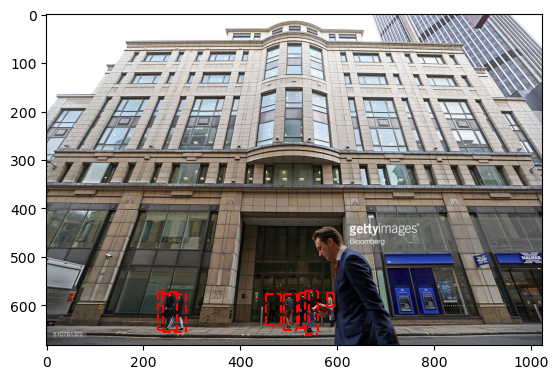

In [47]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

for coord in coords:
    for c in coord:
        plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

#### Plotting YOLO formatted data

Plotting the formatted data to confirm accurate bounding box conversions.  

In [32]:
#Obtain the plotting coords using the bounding box values
def get_plt_coords(bbox, img_width = None, img_height = None):
    x, y, w, h = bbox

    #Non-normalizing the coordinates
    if img_width and img_height:
        x, y, w, h = x*img_width, y*img_height, w*img_width, h*img_height

    #x, y are centered
    return([[[x - w/2, x + w/2], [y - h/2, y - h/2]],
            [[x - w/2, x + w/2], [y + h/2, y + h/2]],
            [[x - w/2, x - w/2], [y - h/2, y + h/2]],
            [[x + w/2, x + w/2], [y - h/2, y + h/2]]])

In [35]:
#Obtaining a sample image
sample_ind = 6

sample_img_path = data_body_dir + r'\images\train'
sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
sample_img = cv2.imread(sample_img_path)

sample_label_path = data_body_dir + r'\labels\train'
sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

with open(sample_label_path, 'r') as f:
    sample_label = f.readlines()

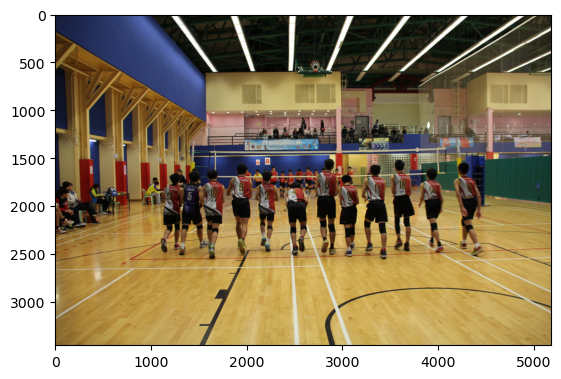

In [36]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

In [37]:
conv_to_floats = lambda row: [float(elem) for pos, elem in enumerate(row.strip().split(' ')) if pos != 0]

sample_label = list(map(conv_to_floats, sample_label))
coords = list(map(lambda bbox: get_plt_coords(bbox, sample_img.shape[1], sample_img.shape[0]), sample_label))

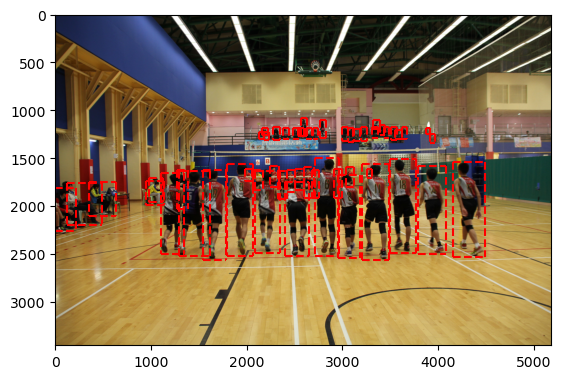

In [38]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

for coord in coords:
    for c in coord:
        plt.plot(c[0], c[1], color = 'red', linestyle = 'dashed')

## YOLOv8

In [41]:
# Load the pretrained YOLOv8 model
#model = YOLO('yolov8n.pt')

#YOLO model YAML file
model_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\ultralytics\cfg\models\v8\yolov8n.yaml'

#YAML files for pretrained weights, finetuned (without blobs) weights, finetuned (with blobs) weights
weights_dir = r'C:\Users\Admin\Documents\GitHub\ultralytics_forked\Vision_Project\yolov8n.pt'
best_weights_dir = r'E:\Telegram_Downloads\detect\main_imgsz1280_frz10_batchnormTrue\weights\best.pt'
blob_best_weights_dir = r'E:\Telegram_Downloads\main_imgsz1280_frz10_batchnormTrue\weights\best.pt'

model = YOLO(model_dir).load(weights_dir)

Transferred 355/355 items from pretrained weights


#### Sharp Blob Detection

This is a pre-processing method to find relevant blobs from the image, in the hope that these capture human faces.  These detected blobs are then sharpened so they stick out from the image, but still maintain a naturality.

The blob detection is carried out by the SimpleBlobDetector method from the OpenCV package.  We define the desired blobs to be constrained in size (minimum area 200), which ensures that persons far away can be detected as blobs and the blobs are large enough to sharpen them.  The faces close by can be easily detected (and thus, doesn't demand detection), while the persons far away can be hard to detect.  Blob-sharpening them can guide the model to detect them better.  We also tune the parameters of circularity, convexity and inertia to make the blobs optimal to detect human faces.

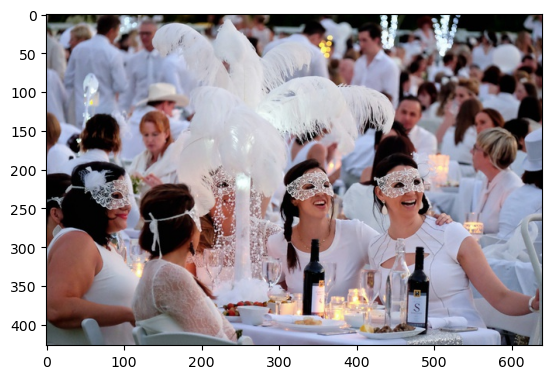

In [5]:
sample_ind = 37

sample_img_path = data_body_dir + r'\images\train'
sample_img_path = sample_img_path + r'\\' + os.listdir(sample_img_path)[sample_ind]
sample_img = cv2.imread(sample_img_path)

sample_label_path = data_body_dir + r'\labels\train'
sample_label_path = sample_label_path + r'\\' + os.listdir(sample_label_path)[sample_ind]

with open(sample_label_path, 'r') as f:
    sample_label = f.readlines()

plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

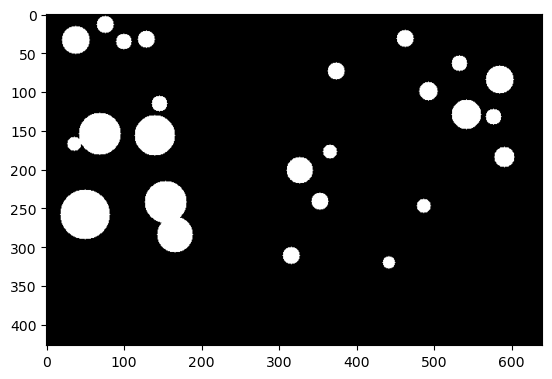

In [296]:
# # Read the image
image = cv2.imread(sample_img_path, cv2.IMREAD_COLOR)

gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Set up SimpleBlobDetector parameters
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 0
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 200

# Filter by Circularity
params.filterByCircularity = True
params.minCircularity = 0.4             #0.78 is square, greater than 0.8 tends to circle
params.maxCircularity = 1

# Filter by Convexity
params.filterByConvexity = False
params.minConvexity = 0.1
params.maxConvexity = 1

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(gray_img)

# Create an empty mask
mask = np.zeros_like(gray_img)

# Draw blobs on the mask
for keypoint in keypoints:
    x, y = np.int64(keypoint.pt)
    r = np.int64(keypoint.size // 2)
    cv2.circle(mask, (x, y), r, (255), -1)


plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.show()

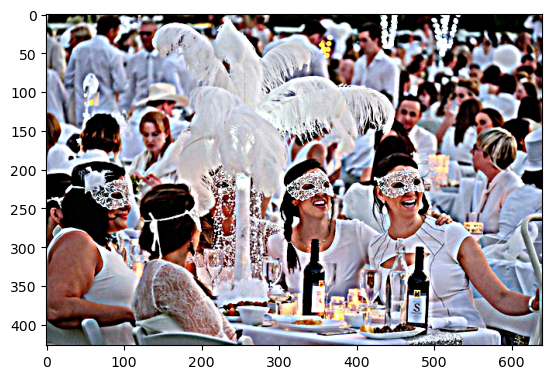

In [297]:
# Sharpen the sample_img using unsharp masking
blurred = cv2.GaussianBlur(sample_img, (15, 15), 7)
sharpened = cv2.addWeighted(sample_img, 3.5, blurred, -2.5, 0)

plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
plt.imshow(cv2.cvtColor(sharpened, cv2.COLOR_BGR2RGB))
plt.show()

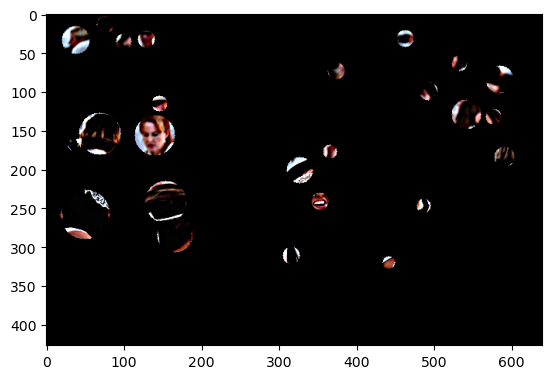

In [298]:
# Split the image into three color channels
sharpened_b, sharpened_g, sharpened_r = cv2.split(sharpened)

# Apply bitwise operations to each color channel
sharp_blobs_b = cv2.bitwise_and(sharpened_b, sharpened_b, mask=mask)
sharp_blobs_g = cv2.bitwise_and(sharpened_g, sharpened_g, mask=mask)
sharp_blobs_r = cv2.bitwise_and(sharpened_r, sharpened_r, mask=mask)

blobs_merge = cv2.merge((sharp_blobs_b, sharp_blobs_g, sharp_blobs_r))

plt.imshow(cv2.cvtColor(blobs_merge, cv2.COLOR_BGR2RGB))
plt.show()

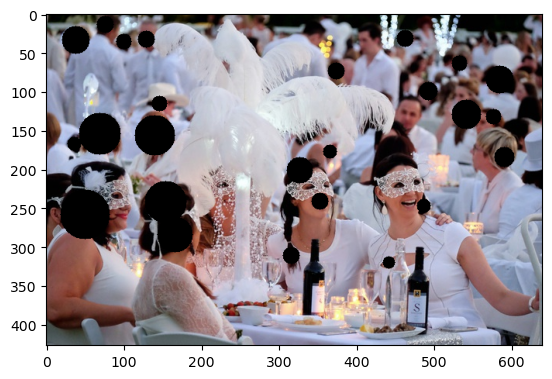

In [299]:
image_b, image_g, image_r = cv2.split(image)

non_sharp_regions_b = cv2.bitwise_and(image_b, image_b, mask=cv2.bitwise_not(mask))
non_sharp_regions_g = cv2.bitwise_and(image_g, image_g, mask=cv2.bitwise_not(mask))
non_sharp_regions_r = cv2.bitwise_and(image_r, image_r, mask=cv2.bitwise_not(mask))

non_sharp_merge = cv2.merge((non_sharp_regions_b, non_sharp_regions_g, non_sharp_regions_r))

plt.imshow(cv2.cvtColor(non_sharp_merge, cv2.COLOR_BGR2RGB))
plt.show()

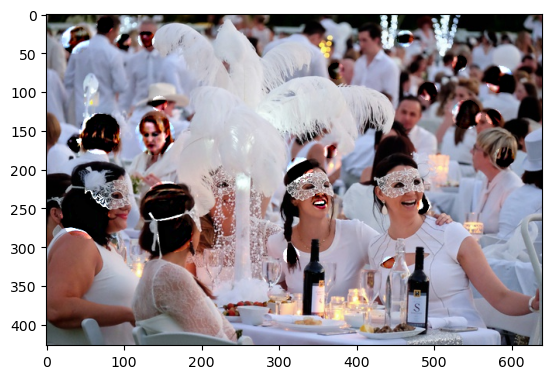

In [300]:
# Combine the sharpened blobs with the non-sharpened regions
result_b = cv2.add(sharp_blobs_b, non_sharp_regions_b)
result_g = cv2.add(sharp_blobs_g, non_sharp_regions_g)
result_r = cv2.add(sharp_blobs_r, non_sharp_regions_r)

# Merge the color channels back into one image
result = cv2.merge((result_b, result_g, result_r))

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

In [301]:
def detect_blobs(image):

    #Convert image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Set up SimpleBlobDetector parameters
    params = cv2.SimpleBlobDetector_Params()

    ##Define Parameters

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = 255

    # Filter by Area.
    params.filterByArea = True          #A minimal bound is set so sharpening has an effect
    params.minArea = 200

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.4             #0.78 is square, greater than 0.8 tends to circle
    #params.maxCircularity = 1

    # Filter by Convexity
    params.filterByConvexity = False        #Faces are detected as concave too, so set to False
    #params.minConvexity = 0.1
    #params.maxConvexity = 1

    # Filter by Inertia
    params.filterByInertia = True           #A minimal bound is set to avoid detecting lines
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs
    keypoints = detector.detect(gray_img)

    # Create an empty mask
    mask = np.zeros_like(gray_img)

    # Draw blobs on the mask
    for keypoint in keypoints:
        x, y = np.int64(keypoint.pt)
        r = np.int64(keypoint.size // 2)
        cv2.circle(mask, (x, y), r, (255), -1)
    
    return(mask)

In [ ]:
def inject_sharp_blobs(image):

    #Obtain blobs
    mask = detect_blobs(image)

    # Sharpen the sample_img using unsharp masking
    blurred = cv2.GaussianBlur(sample_img, (15, 15), 7)
    sharpened = cv2.addWeighted(sample_img, 3.5, blurred, -2.5, 0)


    # Split the sharpened image into three color channels
    # These are then used for obtaining sharp blobs
    sharpened_b, sharpened_g, sharpened_r = cv2.split(sharpened)

    # Apply bitwise operations to each color channel, get sharp blobs
    sharp_blobs_b = cv2.bitwise_and(sharpened_b, sharpened_b, mask=mask)
    sharp_blobs_g = cv2.bitwise_and(sharpened_g, sharpened_g, mask=mask)
    sharp_blobs_r = cv2.bitwise_and(sharpened_r, sharpened_r, mask=mask)


    #Split original image into three color channels
    image_b, image_g, image_r = cv2.split(image)

    #Regions with sharp blobs are blacked out
    non_sharp_regions_b = cv2.bitwise_and(image_b, image_b, mask=cv2.bitwise_not(mask))
    non_sharp_regions_g = cv2.bitwise_and(image_g, image_g, mask=cv2.bitwise_not(mask))
    non_sharp_regions_r = cv2.bitwise_and(image_r, image_r, mask=cv2.bitwise_not(mask))


    # Combine the sharpened blobs with the non-sharpened regions
    result_b = cv2.add(sharp_blobs_b, non_sharp_regions_b)
    result_g = cv2.add(sharp_blobs_g, non_sharp_regions_g)
    result_r = cv2.add(sharp_blobs_r, non_sharp_regions_r)

    # Merge the color channels back into one image
    result = cv2.merge((result_b, result_g, result_r))

    return(result)
    

##### Get Layer Sizes

In [42]:
#Returns the layer sizes in each module as {Module: (layer_name, layer_size)}
def get_layer_sizes(state_dict):

    #Gets layer number given the parameter name
    get_layer_num = lambda name: int(name.split('.')[2])
    n_modules = get_layer_num( list(state_dict.keys())[-1] ) + 1     #Gets total number of modules

    layer_sizes = {}

    #Iterates through each module index
    for module_num in range(n_modules):
        #Gets the param names in a module, and gets the layer sizes for each layer in the module
        param_names = [name for name in state_dict.keys() if get_layer_num(name) == module_num]
        layer_sizes[module_num] = [(param, state_dict[param].shape) for param in param_names]
    
    return(layer_sizes)

In [43]:
layer_sizes = get_layer_sizes(model.state_dict())
layer_sizes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [44]:
for k, v in layer_sizes.items():
    print(f'\n\n Module {k}:')

    for t in v:
        print(f'{t[0]}: {t[1]}\n')



 Module 0:
model.model.0.conv.weight: torch.Size([16, 3, 3, 3])

model.model.0.bn.weight: torch.Size([16])

model.model.0.bn.bias: torch.Size([16])

model.model.0.bn.running_mean: torch.Size([16])

model.model.0.bn.running_var: torch.Size([16])

model.model.0.bn.num_batches_tracked: torch.Size([])



 Module 1:
model.model.1.conv.weight: torch.Size([32, 16, 3, 3])

model.model.1.bn.weight: torch.Size([32])

model.model.1.bn.bias: torch.Size([32])

model.model.1.bn.running_mean: torch.Size([32])

model.model.1.bn.running_var: torch.Size([32])

model.model.1.bn.num_batches_tracked: torch.Size([])



 Module 2:
model.model.2.cv1.conv.weight: torch.Size([32, 32, 1, 1])

model.model.2.cv1.bn.weight: torch.Size([32])

model.model.2.cv1.bn.bias: torch.Size([32])

model.model.2.cv1.bn.running_mean: torch.Size([32])

model.model.2.cv1.bn.running_var: torch.Size([32])

model.model.2.cv1.bn.num_batches_tracked: torch.Size([])

model.model.2.cv2.conv.weight: torch.Size([32, 48, 1, 1])

model.mod

#### Freezing Layers

We manually freeze the layers, and the batch normalization statistics along with it.

In [10]:
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

From the model architecture, we see that the backbone consists of the first 10 layers, the neck consists of the 12 layers after, and the head is the last layer.  This gives a total of 23 layers for the module.

In [11]:
#Get number of parameters in a layer
def get_layer_params(layer_num, model):
    
    params = []
    for k, v in model.named_parameters():   #Gets (name of param, value of param)
        if f'model.{layer_num}.' in k:      #Extracts params corresponding to model layer
            params.append(v)                #Appends layer params to list

    return(sum([p.numel() for p in params]))    #Returns total number of params in layer

n_layers = int(list(model.state_dict().keys())[-1].split('.')[2])


#Gets the number of trainable params after freezing n_freeze layers (freezing from 0 till (n_freeze - 1), the n_freeze layer is not frozen)
n_params_after_freeze = lambda n_freeze, model: sum(list(map(lambda layer_num: get_layer_params(layer_num, model), np.arange(n_freeze, n_layers + 1))))

print(f'Total number of parameters: {n_params_after_freeze(0, model)}\n')
print(f'Trainable params after freezing backbone: {n_params_after_freeze(10, model)}')
print(f'Trainable params after freezing half of neck: {n_params_after_freeze(15, model)}')
print(f'Trainable params after freezing neck: {n_params_after_freeze(22, model)}')
print(f'Trainable params after freezing head: {n_params_after_freeze(23, model)}')

Total number of parameters: 3157200

Trainable params after freezing backbone: 1884544
Trainable params after freezing half of neck: 1736320
Trainable params after freezing neck: 897664
Trainable params after freezing head: 0


In [12]:
#Freezes layers for fine-tuning
def freeze_layer(trainer, freeze_layers):

    model = trainer.model

    #Prints the layers being frozen
    print(f'\nFreezing {len(freeze_layers)} layers: \n {freeze_layers}\n')
    freeze = [f'model.{x}.' for x in freeze_layers]

    #Iterates through all params
    for param_name, param in model.named_parameters():
        param.requires_grad = True  #Sets all params to trainable

        #Sets params belonging to freeze layers as non-trainable (freezing them)
        if any(x in param_name for x in freeze):
            param.requires_grad = False
    
    print(f'{len(freeze_layers)} layers are freezed')
    print(f'Total number of trainable parameters: {sum([p.numel() for p in model.parameters() if p.requires_grad])}\n')

In [13]:
#Disables tracking batch normalization stats, puts bn layers to eval mode
def put_layer_in_eval_mode(trainer, freeze_layers):

    track_layers = []

    #Gets modules for batch normalization, checks if it belongs to a frozen layer
    #If so, it puts the module to eval mode and disables bn stats tracking
    for (name, module) in trainer.model.named_modules():
        if name.endswith('bn') and int(name.split('.')[1]) in freeze_layers:
            module.eval()
            module.track_running_stats = False

            #print(f'{name} put in eval mode')

            layer_num = int(name.split('.')[1])
            if layer_num not in track_layers: track_layers.append(layer_num)
    
    print(f'\nFollowing layers with batch normalization put into eval mode: \n {track_layers} \n')

In [14]:
#Define number of layers to be frozen

#Freezing first n layers (excluding the nth layer)
freeze_layers = np.arange(22)

#Define callback with freezing layers
model.add_callback("on_train_start", lambda trainer: freeze_layer(trainer, freeze_layers))

#Define callback for putting bn layers to eval mode
model.add_callback("on_train_epoch_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))
model.add_callback("on_pretrain_routine_start", lambda trainer: put_layer_in_eval_mode(trainer, freeze_layers))

#Define the baseline state dict for params
params_init_state = copy.deepcopy(model.state_dict())

#### Training and Validating Model

In [ ]:
results = model.train(data = data_body_yaml,
                                verbose = False,
                                imgsz = 640,
                                #freeze = 22,
                                epochs = 10, patience = 5, batch = 32,
                                name = 'CH_trial_single_cls', exist_ok = True,
                                #classes = 80,
                                #cache = True,
                                single_cls = True,
                                #box = 7.5, cls = 0.5,
                                #pose = 0, kobj = 0,
                                val = True, plots = True)

In [ ]:
#For finetuned with blobs
results = model.val(data = data_body_yaml,
                                verbose = False,
                                imgsz = 1280,
                                name = 'val_run_small_1000_test_best_blob', exist_ok = True,
                                save_json = True,
                                #save_hybrid = True,
                                plots = True)

In [ ]:
#Pretrained model
results = model.val(data = data_body_yaml,
                                verbose = False,
                                imgsz = 1280,
                                name = 'val_run_small_1000_test_pt', exist_ok = True,
                                save_json = True,
                                #save_hybrid = True,
                                plots = True)

In [ ]:
#Finetuned model (without blob)
results = model.val(data = data_body_yaml,
                                verbose = False,
                                imgsz = 1280,
                                name = 'val_run_small_1000_test_best', exist_ok = True,
                                save_json = True,
                                #save_hybrid = True,
                                plots = True)

#### Comparing State Dictionaries

This compares the previous and finetuend state dictionaries to make sure the proper layers are being frozen.  By doing this, we ensure the validity of our freezing method.

In [170]:
#Compare the param state dicts, and get where the changes have occurred
def compare_state_dicts(d1, d2):

    #Checks if the model param names are the same for both state dicts
    keys_1, keys_2 = set(d1.keys()), set(d2.keys())
    if keys_1 != keys_2: return('Models have different param names')

    layers_updated = []

    #Iterates through each param
    for key in keys_1:
        if not torch.equal(d1[key], d2[key]):   #If param values different btw state dicts
            print(f'Weights for parameter {key} are different') #Prints the param with varying values
            
            #Appends the layer number (containing changed param) to list
            layer_id = int(key.split('.')[2])
            if layer_id not in layers_updated: layers_updated.append(layer_id)
    
    return(layers_updated)

In [171]:
layers_updated = compare_state_dicts(params_init_state, model.state_dict())
print(f'\n Layers updated: {layers_updated}')

Weights for parameter model.model.22.cv3.2.0.bn.bias are different
Weights for parameter model.model.22.cv2.0.0.bn.bias are different
Weights for parameter model.model.22.cv2.2.1.bn.running_var are different
Weights for parameter model.model.22.cv3.2.2.weight are different
Weights for parameter model.model.22.cv3.0.0.conv.weight are different
Weights for parameter model.model.22.cv3.0.1.conv.weight are different
Weights for parameter model.model.22.cv2.2.0.bn.bias are different
Weights for parameter model.model.22.cv3.1.1.bn.running_var are different
Weights for parameter model.model.22.cv3.0.0.bn.running_var are different
Weights for parameter model.model.22.cv2.1.1.bn.running_mean are different
Weights for parameter model.model.22.cv2.2.0.conv.weight are different
Weights for parameter model.model.22.cv2.1.1.conv.weight are different
Weights for parameter model.model.22.cv3.2.0.bn.running_mean are different
Weights for parameter model.model.22.cv2.1.0.bn.running_mean are different
We